In [1]:
from PIL import Image
import numpy as np
import json
import os
import seaborn as sns
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn

import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader


In [2]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ])

}

In [6]:
train_dataset = datasets.ImageFolder(root='../dataset/dataset/train', transform=transform['train'])
val_dataset = datasets.ImageFolder(root='../dataset/dataset/test', transform=transform['test'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
model = models.vgg16(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(train_dataset.classes))

c:\Users\Sara Tel\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sara Tel\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# from torchsummary import summary

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# summary(model, input_size=(3, 224, 224))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses, val_accuracies = [], [], []
    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model checkpoint saved!")

    return train_losses, val_losses, val_accuracies

Epoch 1/2, Train Loss: 0.3062, Val Loss: 0.1652, Val Acc: 0.9396
Model checkpoint saved!
Epoch 2/2, Train Loss: 0.1907, Val Loss: 0.1697, Val Acc: 0.9121


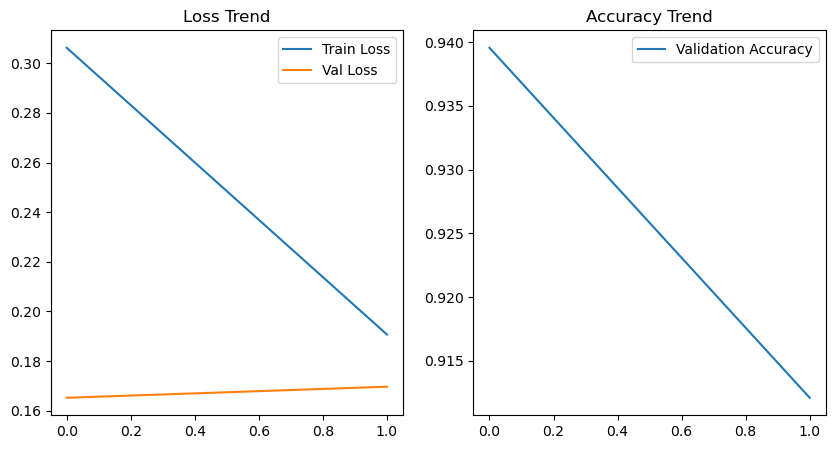

In [11]:
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=2)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Trend')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Trend')
plt.show()

C:\Users\Sara Tel\AppData\Local\Temp\ipykernel_19748\2707348223.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


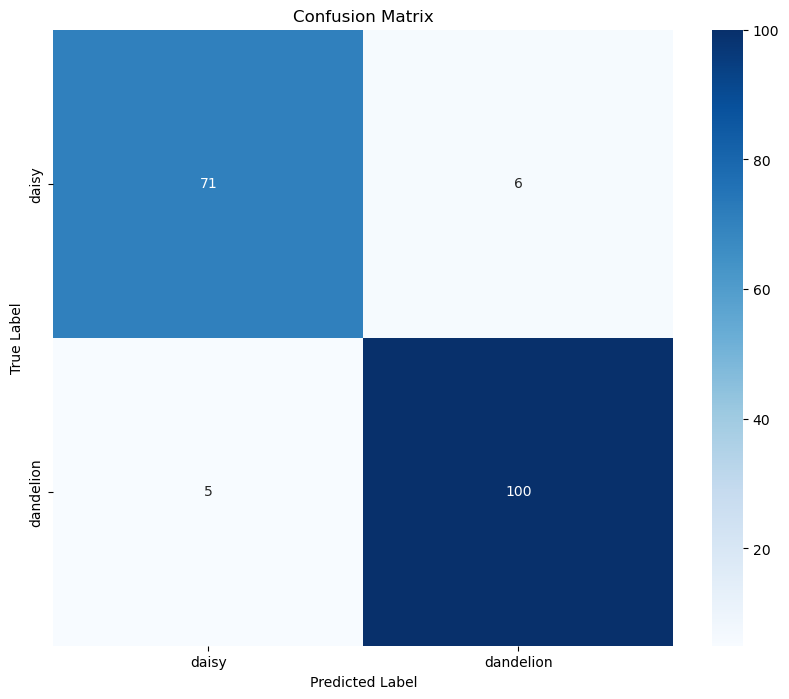

In [12]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

def plot_confusion_matrix(model, dataloader):
    from sklearn.metrics import confusion_matrix
    import pandas as pd

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(model, val_loader)

In [13]:
def infer(image_path, model):
    image = Image.open(image_path).convert('RGB')
    image = transform['test'](image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    k = min(5, probabilities.size(0)) 
    top5_prob, top5_catid = probabilities.topk(k)
    results = [(train_dataset.classes[catid], prob.item()) for catid, prob in zip(top5_catid, top5_prob)]
    return results

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image) 
    plt.axis("off") 
    plt.show()  

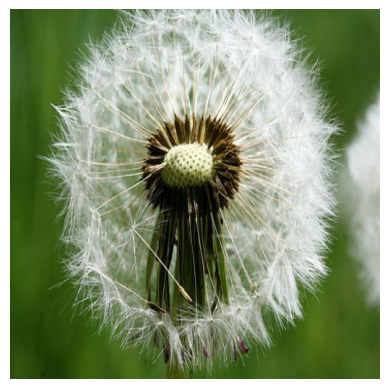

dandelion: 0.9943
daisy: 0.0057


In [20]:
image_path = "../dataset/dataset/test/dandelion/510874382_f7e3435043_jpg.rf.b29f5681a3f5849d65b2efd17365006d.jpg" 
show_image(image_path)
results = infer(image_path, model)
for label, prob in results:
    print(f"{label}: {prob:.4f}")